In [20]:
from time import time
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import f1_score
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, ComplementNB, BernoulliNB
from sklearn.decomposition import FastICA, KernelPCA, TruncatedSVD, SparsePCA, NMF, FactorAnalysis, LatentDirichletAllocation

import nltk



# GLOBAL VARIBLES
df = pd.read_csv("SMSSpamCollection.txt", sep="\t", header=None) 
stopwords = nltk.corpus.stopwords.words("english")
corpus = np.array(df[1])
targets = np.array(df[0])
targets = np.array([ 1 if x == "spam" else 0 for x in targets])


vocabulary size; 8577


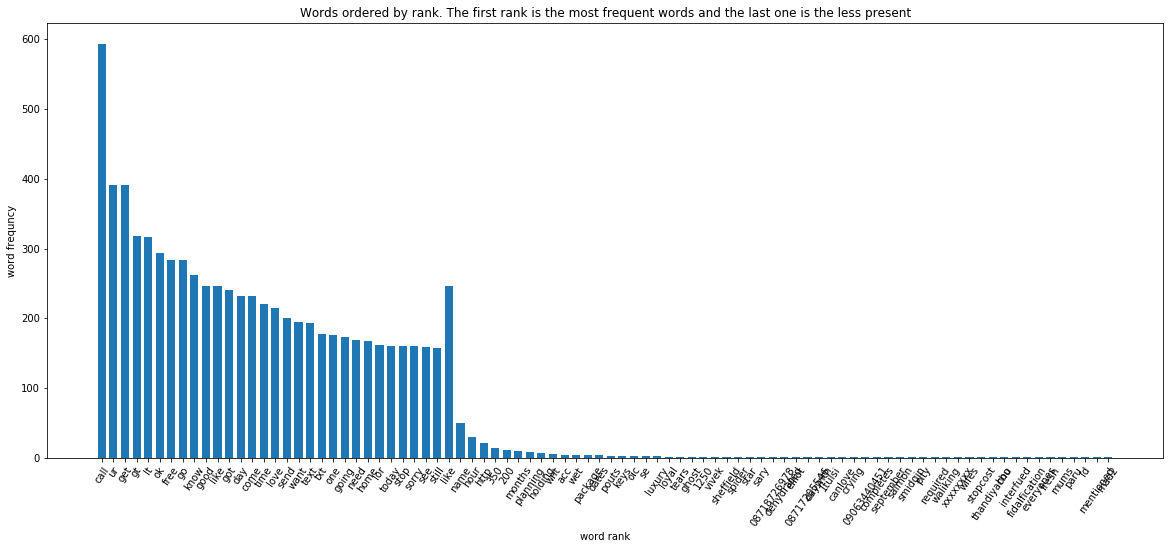

In [3]:
# Vobabulary analysis
vec = CountVectorizer(stop_words=stopwords)
X = vec.fit_transform(corpus)
words = vec.get_feature_names()

print("vocabulary size; %d" % len(words) )

# Compute rank
wsum = np.array(X.sum(0))[0]
ix = wsum.argsort()[::-1]
wrank = wsum[ix] 
labels = [words[i] for i in ix]

# Sub-sample the data to plot.
# take the 20 first + the rest sample with the given step 
def subsample(x, step=150):
    return np.hstack((x[:30], x[10::step]))


plt.figure(figsize=(20,8))
freq = subsample(wrank)
r = np.arange(len(freq))
plt.bar(r, freq, width=0.7)
plt.xticks(r, subsample(labels), rotation=55)
plt.xlabel('word rank')
plt.ylabel('word frequncy')
plt.title("Words ordered by rank. The first rank is the most frequent words and the last one is the less present");


In [28]:
pipe0 = Pipeline([
    ('vect', CountVectorizer()),
    ('sgd', SGDClassifier()),
])
pipe1 = Pipeline([
    ('vect', CountVectorizer()),
    ('svm', SVC()),
])
pipe2 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier()),
])
pipe3 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svml', LinearSVC()),
])
pipe4 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC()),
])
pipe5 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logit', LogisticRegression()),
])
pipe6 = Pipeline([
    ('vect', CountVectorizer()),
    ('mult_nb', MultinomialNB()),
])
pipe7 = Pipeline([
    ('vect', CountVectorizer()),
    ('compl_nb', ComplementNB()),
])
pipe8 = Pipeline([
    ('vect', CountVectorizer()),
    ('bern_nb', BernoulliNB()),
])

def run_pipes(pipes, splits=10, test_size=0.2, seed=42):  
    res = defaultdict(list)
    spliter = ShuffleSplit(n_splits=splits, test_size=test_size, random_state=seed)
    for idx_train, idx_test in spliter.split(corpus):
        for pipe in pipes:
            # name of the model
            name = "-".join([x[0] for x in pipe.steps])
            
            # extract datasets
            X_train = corpus[idx_train]
            X_test = corpus[idx_test]
            y_train = targets[idx_train]
            y_test = targets[idx_test]
            
            # Learn
            start = time()
            pipe.fit(X_train, y_train)
            fit_time = time() - start
            
            # predict and save results
            y = pipe.predict(X_test)
            res[name].append([
                fit_time,
                f1_score(y_test, y, pos_label=1),
                f1_score(y_test, y, pos_label=0),
            ])
    return res

def print_table(res):
    # Compute mean and std
    final = {}
    for model in res:
        arr = np.array(res[model])
        final[model] = {
            "time" : arr[:, 0].mean().round(2),
            "f1_spam": [arr[:,1].mean().round(3), arr[:,1].std().round(3)],
            "f1_ham": [arr[:,2].mean().round(3), arr[:,2].std().round(3)],
        }

    df = pd.DataFrame.from_dict(final, orient="index").round(3)
    return df

In [ ]:
# run base pipes
res = run_pipes([pipe0, pipe1, pipe2, pipe3, pipe4, pipe5, pipe6, pipe7, pipe8], splits=1)

In [33]:
print_table(res)

,time,f1_spam,f1_ham
vect-sgd,0.14,"[0.951, 0.0]","[0.993, 0.0]"
vect-svm,1.41,"[0.947, 0.0]","[0.992, 0.0]"
vect-tfidf-sgd,0.14,"[0.969, 0.0]","[0.995, 0.0]"
vect-tfidf-svml,0.12,"[0.969, 0.0]","[0.995, 0.0]"
vect-tfidf-svm,1.78,"[0.958, 0.0]","[0.994, 0.0]"
vect-tfidf-logit,0.19,"[0.904, 0.0]","[0.987, 0.0]"
vect-mult_nb,0.10,"[0.969, 0.0]","[0.995, 0.0]"
vect-compl_nb,0.10,"[0.931, 0.0]","[0.989, 0.0]"
vect-bern_nb,0.09,"[0.928, 0.0]","[0.99, 0.0]"


In [35]:
# run the last best with stopwords
pipe01 = Pipeline([
    ('vect-stop', CountVectorizer(strip_accents="unicode", stop_words=stopwords)),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier()),
])
pipe02 = Pipeline([
    ('vect', CountVectorizer(strip_accents="unicode", stop_words=stopwords)),
    ('mult_nb', MultinomialNB()),
])
res = run_pipes([pipe01, pipe02])
print_table(res)

,time,f1_spam,f1_ham
vect-stop-tfidf-sgd,0.13,"[0.95, 0.013]","[0.992, 0.002]"
vect-mult_nb,0.11,"[0.943, 0.011]","[0.991, 0.002]"


In [40]:
# run the last best with ngram
pipe77 = Pipeline([
    ("ngram", CountVectorizer(ngram_range=(1,2), min_df=2)),
    ('tfidf', TfidfTransformer()),
    ('sgd', SGDClassifier(max_iter=5000, tol=1e-4)),
])
pipe78 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2), min_df=2)),
    ('mult_nb', MultinomialNB()),
])
res = run_pipes([pipe77, pipe78])
print_table(res)

,time,f1_spam,f1_ham
ngram-tfidf-sgd,0.30,"[0.952, 0.012]","[0.993, 0.002]"
vect-mult_nb,0.28,"[0.942, 0.015]","[0.991, 0.003]"


In [88]:
# run the last best with dimensionality reduction

# too long...
#pipe10 = Pipeline([
#    ('ngram', CountVectorizer(ngram_range=(1,2))),
#    ('tfidf', TfidfTransformer()),
#    ('pca', KernelPCA()),
#    ('sgd', SGDClassifier()),
#])
#pipe11 = Pipeline([
#    ('ngram', CountVectorizer(ngram_range=(1,2))),
#    ('tfidf', TfidfTransformer()),
#    ('spca', SparsePCA()),
#    ('sgd', SGDClassifier()),
#])
pipe12 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('nmf', NMF(n_components=50)),
    ('sgd', SGDClassifier()),
])
pipe13 = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svd', TruncatedSVD(n_components=50)),
    ('sgd', SGDClassifier()),
])
pipe14 = Pipeline([
    ('vect', CountVectorizer()),
    ('lda', LatentDirichletAllocation(n_components=50)),
    ('sgd', SGDClassifier()),
])
res = run_pipes([pipe12, pipe13, pipe14], splits=3)
print_table(res)

,time,f1_spam,f1_ham
vect-tfidf-nmf-sgd,12.91,"[0.488, 0.033]","[0.949, 0.003]"
vect-tfidf-svd-sgd,0.43,"[0.88, 0.007]","[0.982, 0.002]"
vect-lda-sgd,23.69,"[0.478, 0.114]","[0.948, 0.008]"


In [87]:
# Try dimensionality reduction with a larger number of components
pipe20 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('nmf', NMF(n_components=100)),
    ('sgd', SGDClassifier()),
])
pipe21 = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('svd', TruncatedSVD(n_components=100)),
    ('sgd', SGDClassifier()),
])
res = run_pipes([pipe20, pipe21], splits=3)
print_table(res)

,time,f1_spam,f1_ham
vect-nmf-sgd,118.49,"[0.811, 0.02]","[0.976, 0.002]"
vect-svd-sgd,3.12,"[0.942, 0.008]","[0.991, 0.001]"


In [311]:
# Try some feature unions : https://scikit-learn.org/stable/modules/compose.html#combining-estimators
pipe30 = Pipeline([
    ('feat', FeatureUnion([
        ("decomposition", Pipeline([
                ("c", CountVectorizer(stop_words=stopwords, min_df=3)),
                ('lda', LatentDirichletAllocation(n_components=25)),
        ])),
        ("tfidf", Pipeline([
                ("c", CountVectorizer(ngram_range=(1,2))),
                ('t', TfidfTransformer()),            
        ]))
    ])),
    ('sgd', SGDClassifier(max_iter=5000, tol=1e-4)),
])
res = run_pipes([pipe30])
print_table(res)

,time,f1_spam,f1_ham
feat-sgd,13.66,"[0.965, 0.007]","[0.995, 0.001]"
